# Evaluating Bot Performance (Chess)

In [1]:
import os
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

parent = '/'.join(s for s in os.getcwd().split('/')[:-1])
print(parent)

/Users/benbellerose/Documents/GitHub/chappie.ai


In [2]:
import pandas as pd

ai = 'test_V2'

game_df = pd.read_csv(f'{parent}/skills/chess/data/models/{ai}/logs/game_log.csv')
game_df.head(5)

,state0,state1,state2,state3,state4,state5,state6,state7,state8,state9,...,prob4092,prob4093,prob4094,prob4095,action,value,reward,ELO,Game-ID,Date
0,0.0,12.0,10.0,11.0,13.0,14.0,11.0,10.0,12.0,9.0,...,0.0,0.0,0.0,0.0,3494.0,-1.0,0.0,NaN,TNPFHNVOQSLYQT6,2022-01-31 19:49:38.102439
1,1.0,12.0,10.0,11.0,13.0,14.0,11.0,10.0,12.0,9.0,...,0.0,0.0,0.0,0.0,405.0,1.0,0.0,NaN,TNPFHNVOQSLYQT6,2022-01-31 19:49:38.102439
2,0.0,12.0,10.0,11.0,13.0,14.0,11.0,2.0,12.0,9.0,...,0.0,0.0,0.0,0.0,3307.0,-1.0,0.0,NaN,TNPFHNVOQSLYQT6,2022-01-31 19:49:38.102439
3,1.0,12.0,10.0,11.0,13.0,14.0,11.0,2.0,12.0,9.0,...,0.0,0.0,0.0,0.0,1375.0,1.0,0.0,NaN,TNPFHNVOQSLYQT6,2022-01-31 19:49:38.102439
4,0.0,12.0,10.0,11.0,13.0,14.0,11.0,2.0,12.0,9.0,...,0.0,0.0,0.0,0.0,3437.0,-1.0,0.0,NaN,TNPFHNVOQSLYQT6,2022-01-31 19:49:38.102439


## Game Play

In [3]:
def parse_move(move):
    x_map = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'] #Board x representation
    y_map = ['8', '7', '6', '5', '4', '3', '2', '1'] #Board y representation
    b_a = int(move['action'])
    a_map = np.zeros(4096)
    a_map[b_a] = 1
    a_map = a_map.reshape((8,8,8,8))
    a_index = [(cy, cx, ny, nx) for cy, cx, ny, nx in zip(*np.where(a_map == 1))][0]
    c_p = f'{x_map[a_index[1]]}{y_map[a_index[0]]}'
    n_p = f'{x_map[a_index[3]]}{y_map[a_index[2]]}'
    return (c_p, n_p)

### Win Distrubution

Knowing the win distrabution helps know how balanced our training data is being.

In [4]:
results = []
for g, g_df in game_df.groupby('Game-ID'):
    results.append({'game':g, 'result':g_df.iloc[0]['value'], 'duration':len(g_df)})
results = pd.DataFrame(results)
print(f'Total Games Played = {len(results)}')
results['result'].value_counts(normalize=True).to_frame().T

Total Games Played = 152


,-1.0,1.0,0.0
result,0.552632,0.388158,0.059211


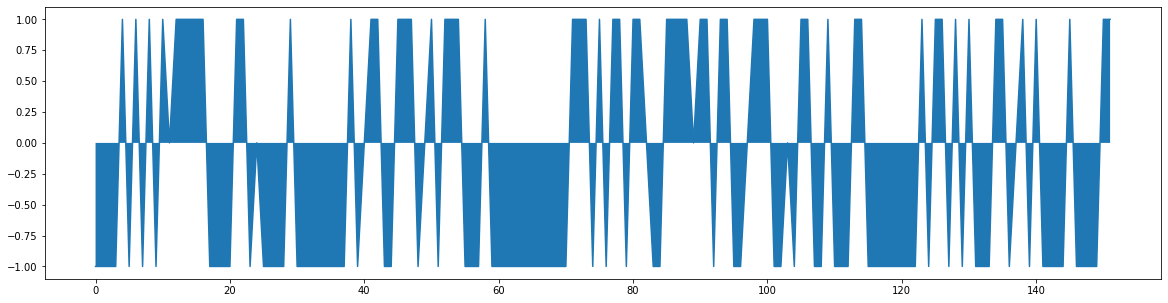

In [5]:
results['result'].plot.line(figsize=(20, 5), legend=False)
plt.fill_between(results.index,results['result'])
plt.show()

### Duration

<AxesSubplot:>

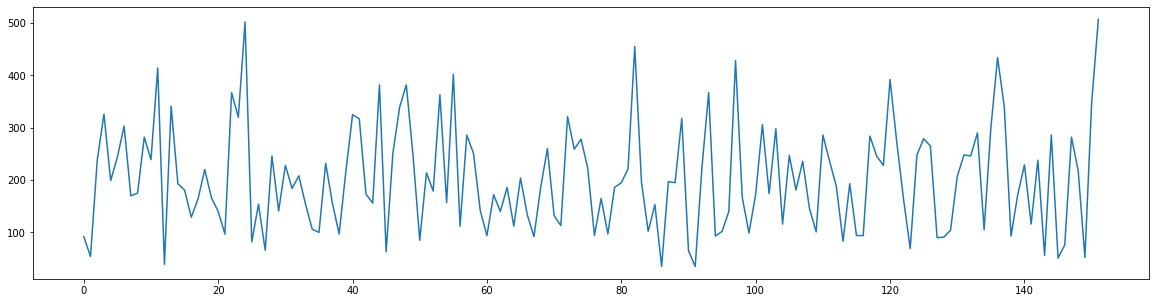

In [6]:
results['duration'].plot.line(figsize=(20, 5), legend=False)

### White Opening Moves

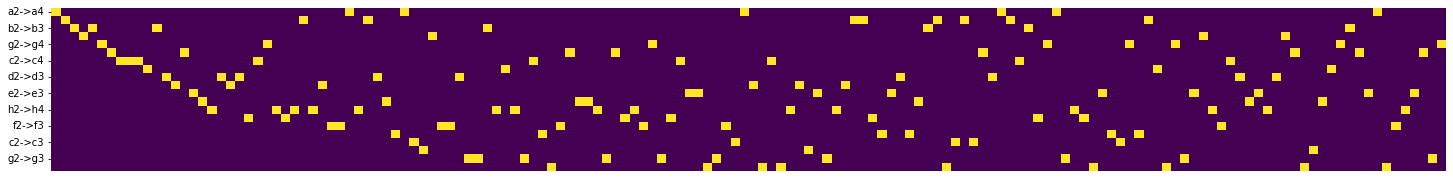

In [7]:
o_results = []
for g, g_log in game_df.groupby('Game-ID'):
    c_pos, n_pos = parse_move(g_log.iloc[0])
    o_results.append({f'{c_pos}->{n_pos}':1})
o_results = pd.DataFrame(o_results).fillna(0).T

plt.rcParams['figure.figsize'] = [25, 3] #Resize graph 
sb.heatmap(o_results, cmap='viridis', cbar=False, xticklabels=False, linewidths=0)
plt.show()

### Black Opening Moves

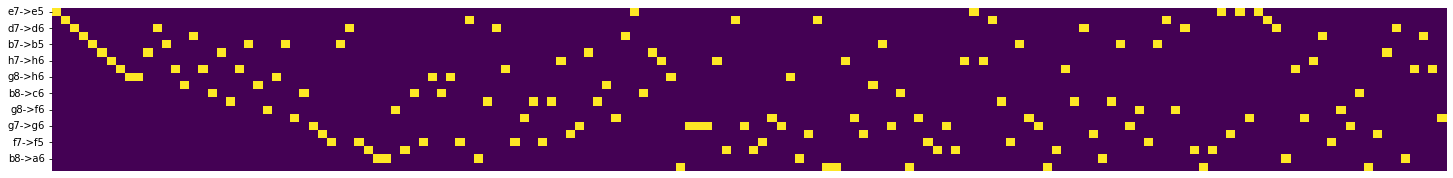

In [8]:
o_results = []
for g, g_log in game_df.groupby('Game-ID'):
    c_pos, n_pos = parse_move(g_log.iloc[1])
    o_results.append({f'{c_pos}->{n_pos}':1})
o_results = pd.DataFrame(o_results).fillna(0).T

plt.rcParams['figure.figsize'] = [25, 3] #Resize graph 
sb.heatmap(o_results, cmap='viridis', cbar=False, xticklabels=False, linewidths=0)
plt.show()

### Game Action Probabilities

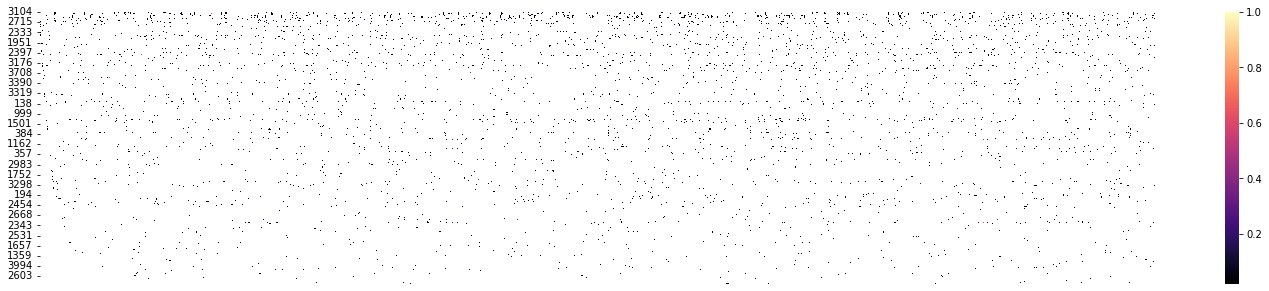

In [9]:
p_headers = [h for h in game_df if 'prob' in h]

a_probs = []
for i, row in game_df[p_headers].iterrows():
    a_probs.append({k.replace('prob',''):v for k, v in row[(row > 0)].to_dict().items()})

a_probs = pd.DataFrame(a_probs)
plt.rcParams['figure.figsize'] = [25, 5] #Resize graph 
sb.heatmap(a_probs.T, cmap='magma', xticklabels=False, linewidths=0)
plt.show()

### Game Tree

In [10]:
'''
s_headers = [h for h in game_df if 'state' in h]
p_headers = [h for h in game_df if 'prob' in h]

tree = {}
for i, row in game_df.iterrows():
    s_hash = hash(str(row[s_headers].tolist()))
    tree[(s_hash)] = 
    break
print(tree)


import matplotlib.pyplot as plt
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

G = nx.Graph()
for s in search.tree:
    for a in search.tree[s].n_s:
        G.add_edge(s,a)
        
pos = graphviz_layout(G, prog='dot')
#Display network graph -----------------------------
nx.draw(
    G, #Graph nodes & connections
    pos, #Position of graph
    with_labels=True #Labels on nodes
)
plt.rcParams['figure.figsize'] = [40, 40] #Resize graph
plt.show()
'''

"\ns_headers = [h for h in game_df if 'state' in h]\np_headers = [h for h in game_df if 'prob' in h]\n\ntree = {}\nfor i, row in game_df.iterrows():\n    s_hash = hash(str(row[s_headers].tolist()))\n    tree[(s_hash)] = \n    break\nprint(tree)\n\n\nimport matplotlib.pyplot as plt\nimport networkx as nx\nimport pydot\nfrom networkx.drawing.nx_pydot import graphviz_layout\n\nG = nx.Graph()\nfor s in search.tree:\n    for a in search.tree[s].n_s:\n        G.add_edge(s,a)\n        \npos = graphviz_layout(G, prog='dot')\n#Display network graph -----------------------------\nnx.draw(\n    G, #Graph nodes & connections\n    pos, #Position of graph\n    with_labels=True #Labels on nodes\n)\nplt.rcParams['figure.figsize'] = [40, 40] #Resize graph\nplt.show()\n"

### ELO Rating

<AxesSubplot:>

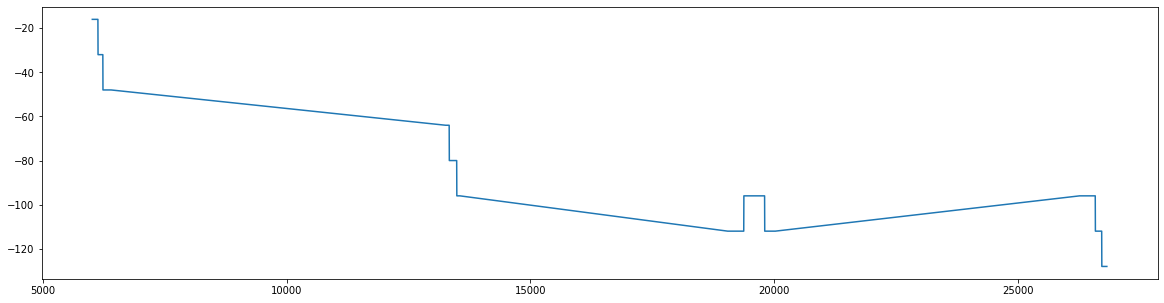

In [24]:
game_df['ELO'].dropna().plot.line(figsize=(20, 5), legend=False)

## Training Results

In [11]:
training_df = pd.read_csv(f'{parent}/skills/chess/data/models/{ai}/logs/training_log.csv')
training_df.head(5)

,Date,Epoch,Samples,Time,hidden loss,backbone loss,Cca loss,value loss,policy loss,state loss,reward loss,model
0,2022-01-31 19:49:06.156105,0,164,3.364375,1.104290,2.132445,0.0,1.053563,0.002288,1.027384,0.062979,skills/chess/data/models/test_V2
1,2022-01-31 19:49:09.644513,1,164,6.852797,1.041137,2.083440,0.0,1.019779,0.002273,1.048836,0.026556,skills/chess/data/models/test_V2
2,2022-01-31 19:49:12.988178,2,164,10.196456,1.027635,2.037216,0.0,0.980958,0.002271,1.033040,0.016578,skills/chess/data/models/test_V2
3,2022-01-31 19:49:16.270610,3,164,13.478879,0.998805,2.014656,0.0,0.967324,0.002271,1.030603,0.017581,skills/chess/data/models/test_V2
4,2022-01-31 19:49:19.575696,4,164,16.783964,1.023498,2.053467,0.0,1.001984,0.002271,1.033519,0.015237,skills/chess/data/models/test_V2


### Hidden Layer Loss

<AxesSubplot:>

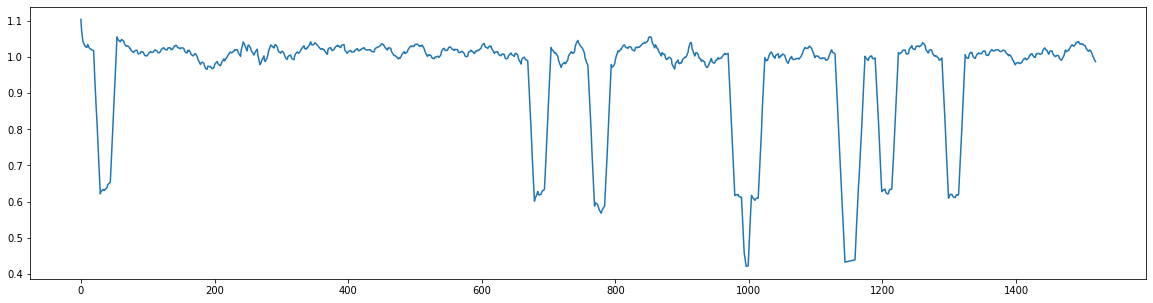

In [12]:
training_df['hidden mavg'] = training_df['hidden loss'].rolling(window=25, min_periods=1).mean()
#print(training_df['hidden mavg'])
training_df[training_df['hidden mavg'] > training_df['hidden mavg'].quantile(0.01)]['hidden mavg'].plot.line(figsize=(20, 5), legend=False)

### Backbone Layer Loss

<AxesSubplot:>

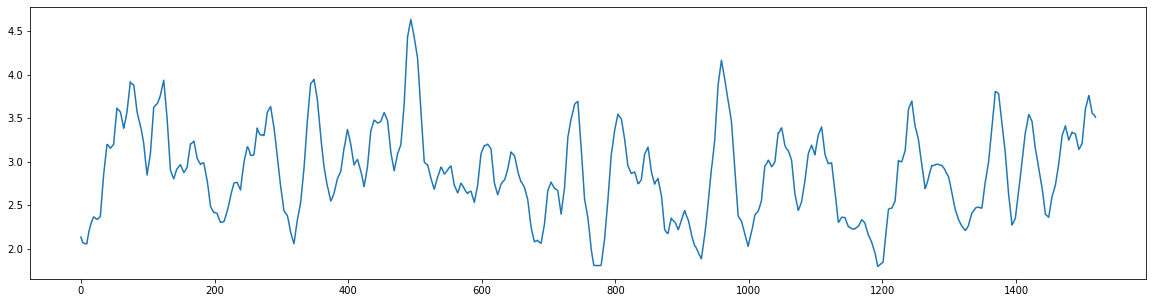

In [13]:
training_df['backbone mavg'] = training_df['backbone loss'].rolling(window=25, min_periods=1).mean()
#print(training_df['backbone mavg'])
training_df[training_df['backbone mavg'] > training_df['backbone mavg'].quantile(0.01)]['backbone mavg'].plot.line(figsize=(20, 5), legend=False)

### Chunked Cross Attention Layer Loss

<AxesSubplot:>

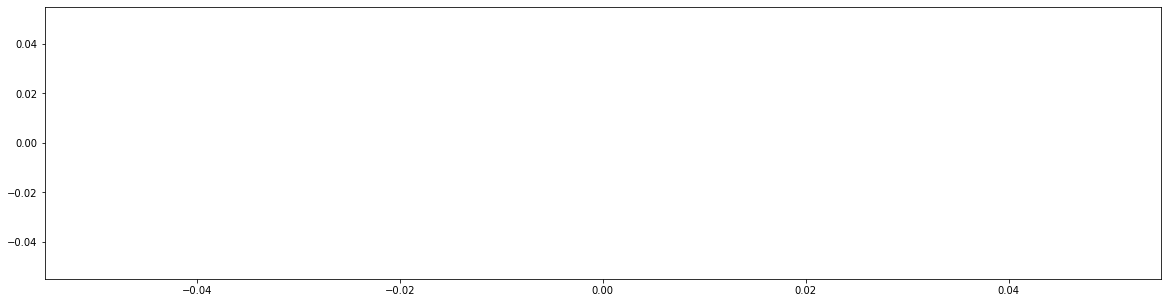

In [14]:
training_df['Cca mavg'] = training_df['Cca loss'].rolling(window=25, min_periods=1).mean()
#print(training_df['Cca mavg'])
training_df[training_df['Cca mavg'] > training_df['Cca mavg'].quantile(0.01)]['Cca mavg'].plot.line(figsize=(20, 5), legend=False)

### Value Head Loss

<AxesSubplot:>

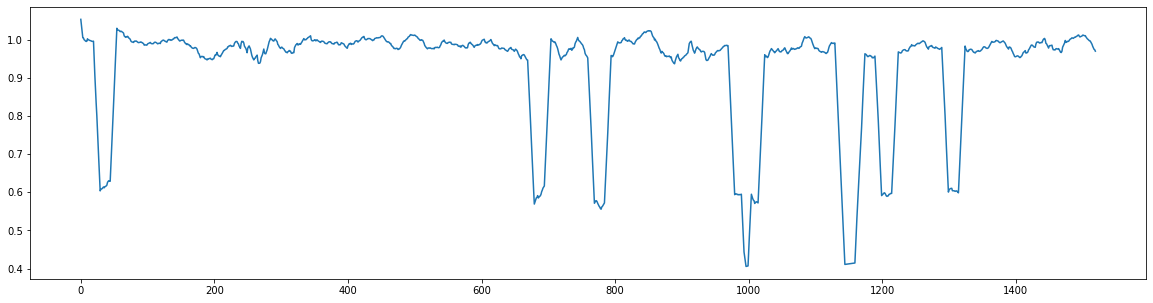

In [15]:
training_df['value mavg'] = training_df['value loss'].rolling(window=25, min_periods=1).mean()
#print(training_df['value mavg'])
training_df[training_df['value mavg'] > training_df['value mavg'].quantile(0.01)]['value mavg'].plot.line(figsize=(20, 5), legend=False)

### Policy Head Loss

<AxesSubplot:>

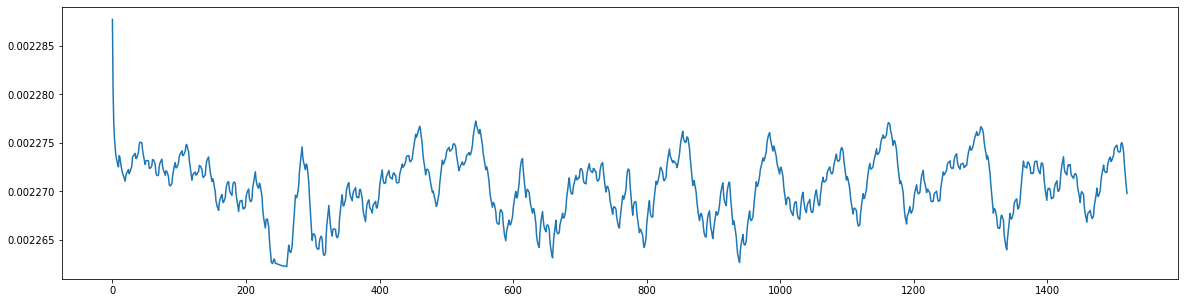

In [16]:
training_df['policy mavg'] = training_df['policy loss'].rolling(window=25, min_periods=1).mean()
#print(training_df['volicy mavg'])
training_df[training_df['policy mavg'] > training_df['policy mavg'].quantile(0.01)]['policy mavg'].plot.line(figsize=(20, 5), legend=False)

### Next State Head Loss

<AxesSubplot:>

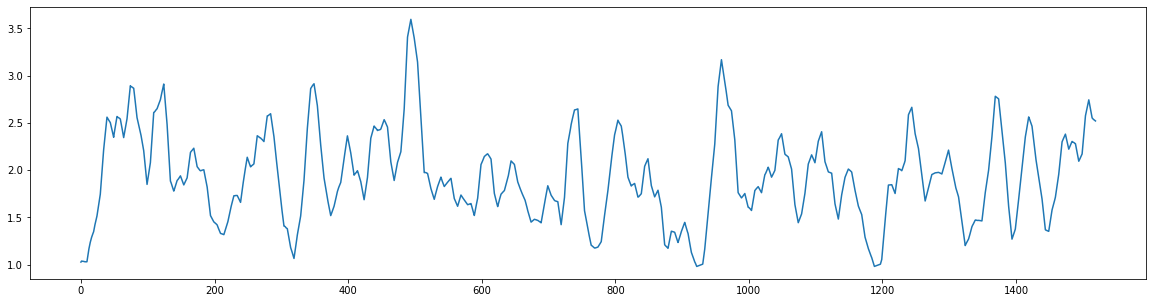

In [17]:
training_df['state mavg'] = training_df['state loss'].rolling(window=25, min_periods=1).mean()
#print(training_df['volicy mavg'])
training_df[training_df['state mavg'] > training_df['state mavg'].quantile(0.01)]['state mavg'].plot.line(figsize=(20, 5), legend=False)

### Reward Head Loss

<AxesSubplot:>

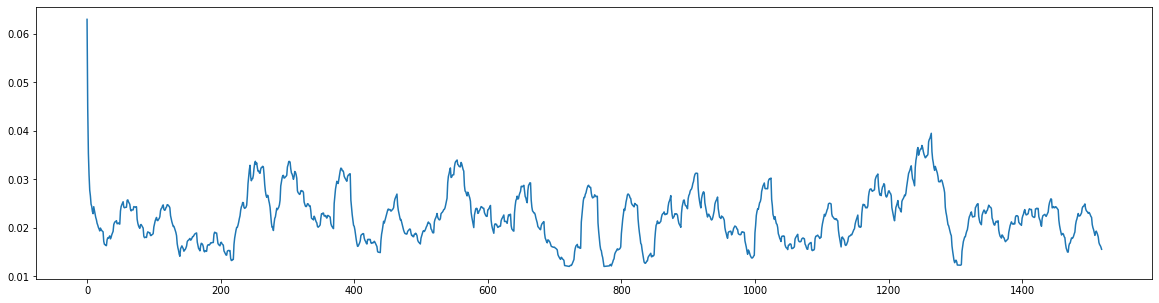

In [18]:
training_df['reward mavg'] = training_df['reward loss'].rolling(window=25, min_periods=1).mean()
#print(training_df['reward mavg'])
training_df[training_df['reward mavg'] > training_df['reward mavg'].quantile(0.01)]['reward mavg'].plot.line(figsize=(20, 5), legend=False)